# Import package and run the dataset

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
%matplotlib inline
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from datetime import date

from sklearn.preprocessing import MinMaxScaler

In [2]:
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
transaction = pd.read_csv("transaction_data.csv", parse_dates=['txn_time'], \
                          date_parser= dateparse)
transaction.dtypes

txn_time          datetime64[ns]
txn_date                  object
order_id                   int64
uid                        int64
shop_id                    int64
shop_owner_uid             int64
gmv                        int64
rebate                     int64
dtype: object

In [3]:
transaction['txn_time'] = pd.to_datetime(transaction['txn_time'])

In [4]:
transaction['date'] = transaction['txn_time'].dt.date
transaction['time'] = transaction['txn_time'].dt.time

In [5]:
transaction.dtypes

txn_time          datetime64[ns]
txn_date                  object
order_id                   int64
uid                        int64
shop_id                    int64
shop_owner_uid             int64
gmv                        int64
rebate                     int64
date                      object
time                      object
dtype: object

In [6]:
transaction.drop(columns=['txn_date'], inplace=True)

In [7]:
len(transaction['shop_id'].unique()) # has 1385 shop
len(transaction['shop_owner_uid'].unique()) # has 1277 shop_owner => maybe 1 owner has more than 1 shop

1277

In [8]:
def rebate_test(value):
    rebate = value * 0.3
    if rebate >= 20000:
        rebate = 20000

    return rebate


In [9]:
transaction['rebate_using'] = transaction['rebate'] != 0
transaction['rebate_using'] = transaction['rebate_using'].map({False: 0, True: 1})
transaction['order_value'] = transaction['gmv'] - transaction['rebate']
transaction['rebate_test'] = transaction['gmv'].apply(rebate_test)

There are customers who do not use promotional codes.

Possible reasons could be:

1. Not meeting the conditions for using the code.

2. Intentionally not using the code due to the shop's policy, which depends on the shop's guidelines.

=> Issues for consideration:

1. Review if there is any unusual increase in revenue.

1. On days with an abnormal increase, determine the total usage of promotional codes.

In [10]:
transaction['date'].value_counts()

date
2019-11-02    1529
2019-10-31    1086
2019-11-01    1060
2019-10-30     936
Name: count, dtype: int64

In [11]:
transaction['gmv'].describe().apply(lambda x: format(x, 'f'))

count       4611.000000
mean      138985.275862
std       193990.408745
min            1.000000
25%        70000.000000
50%        84926.000000
75%       139000.000000
max      3750000.000000
Name: gmv, dtype: object

In [12]:
transaction['order_value'].describe().apply(lambda x: format(x, 'f'))

count       4611.000000
mean      122171.767512
std       192668.182532
min            1.000000
25%        50000.000000
50%        65000.000000
75%       120000.000000
max      3730000.000000
Name: order_value, dtype: object

The chart skews to the left when the mean > median, indicating that the majority of customers make purchases at lower values, while a minority buy at higher values.


In [13]:
bin_edges = [0, 1000, 5000, 67000, 100000, 200000,500000, 1000000, 3750000]
transaction['gmv_group'] = pd.cut(transaction['gmv'],bins=bin_edges)
transaction['gmv_group'].value_counts()

gmv_group
(67000, 100000]       1894
(5000, 67000]          960
(100000, 200000]       897
(200000, 500000]       545
(0, 1000]              139
(500000, 1000000]      139
(1000000, 3750000]      36
(1000, 5000]             1
Name: count, dtype: int64

In [14]:
gmv_table = transaction[['order_id','gmv','gmv_group','rebate_using']]
gmv_group = gmv_table.groupby(by=['gmv_group']).\
            agg(
                gmv_mean=('gmv', 'mean'),
                total_order = ('order_id', 'size'),
                total_rebate_using =('rebate_using','sum')
            )
gmv_group['gmv_mean'] = gmv_group['gmv_mean'].apply(lambda x: format(x,'f'))
gmv_group['pct_rebate_use'] = gmv_group['total_rebate_using'] / gmv_group['total_order'] * 100
gmv_group['pct_rebate_use'] = gmv_group['pct_rebate_use'].round(2)
gmv_group

,gmv_mean,total_order,total_rebate_using,pct_rebate_use
gmv_group,,,,
"(0, 1000]",135.489209,139,0,0.00
"(1000, 5000]",3000.000000,1,0,0.00
"(5000, 67000]",41366.852083,960,749,78.02
"(67000, 100000]",81563.530623,1894,1826,96.41
"(100000, 200000]",141637.464883,897,857,95.54
"(200000, 500000]",309177.633028,545,522,95.78
"(500000, 1000000]",681339.230216,139,135,97.12
"(1000000, 3750000]",1566361.111111,36,34,94.44


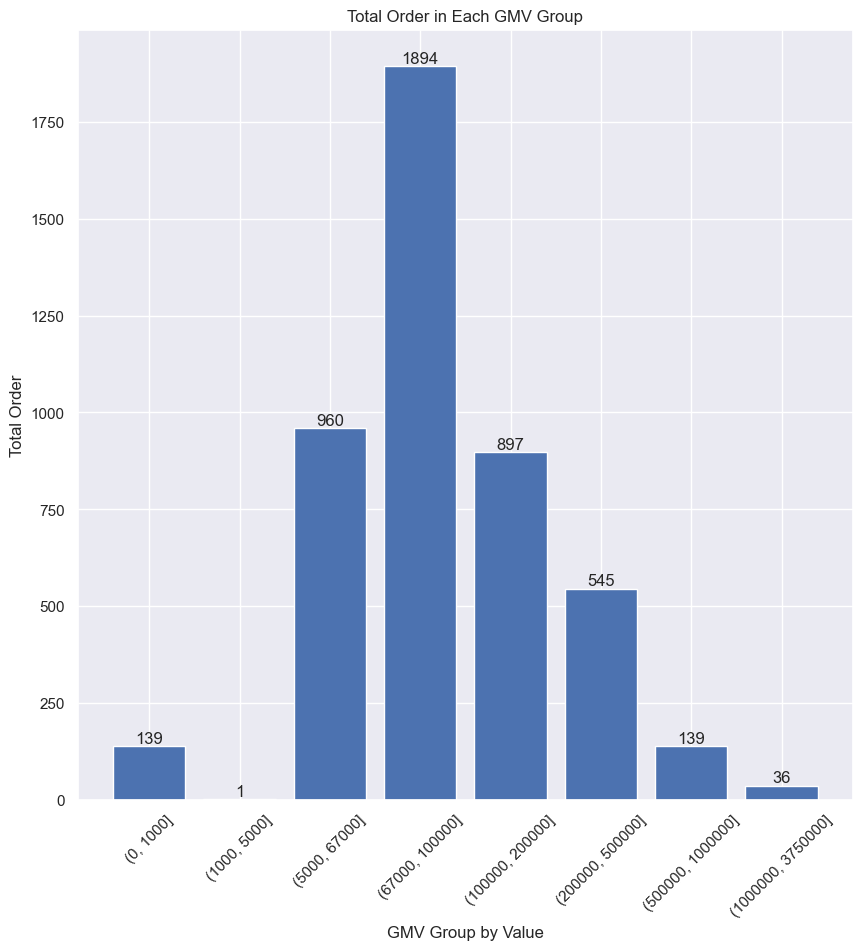

In [15]:
# Create percentage
fig, ax = plt.subplots(figsize=(10,10))

bar_order = plt.bar(gmv_group.index.astype(str), gmv_group['total_order'])

plt.xticks(rotation=45)
plt.xlabel('GMV Group by Value')
plt.ylabel('Total Order')

plt.title('Total Order in Each GMV Group')

ax.bar_label(bar_order)

plt.show(bar_order)

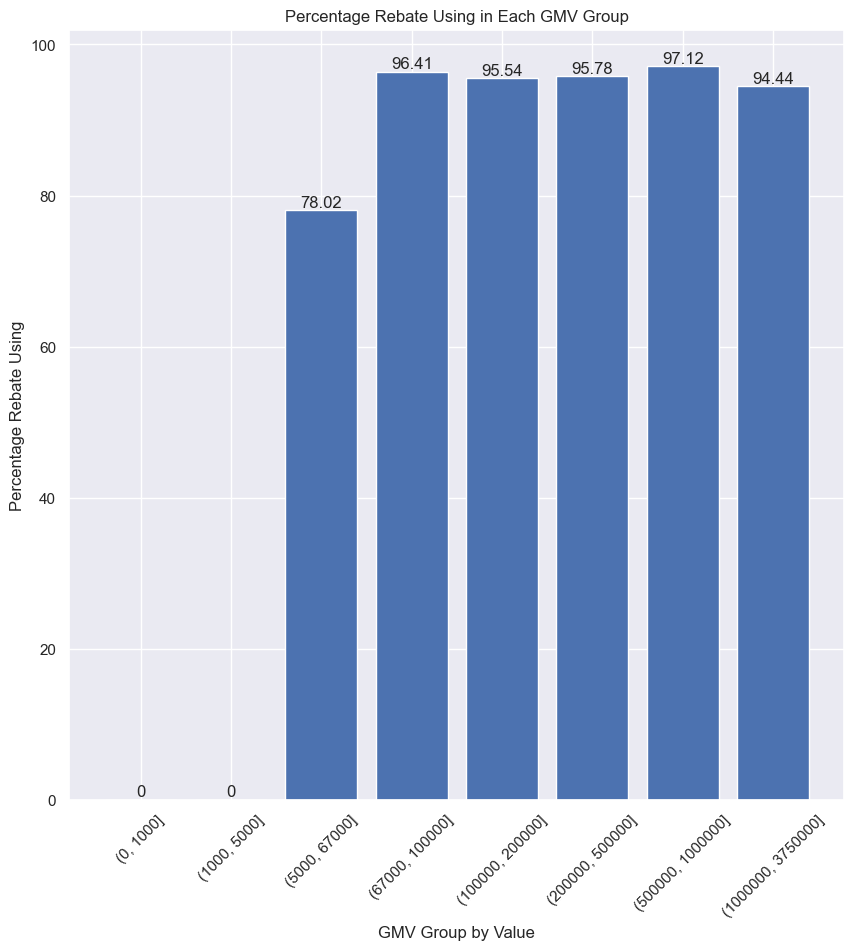

In [16]:
# Create percentage
fig, ax = plt.subplots(figsize=(10,10))

bar_order_1 = plt.bar(gmv_group.index.astype(str), gmv_group['pct_rebate_use'])

plt.xticks(rotation=45)
plt.xlabel('GMV Group by Value')
plt.ylabel('Percentage Rebate Using')

plt.title('Percentage Rebate Using in Each GMV Group')

ax.bar_label(bar_order_1)

plt.show(bar_order_1)

<Axes: xlabel='gmv', ylabel='Count'>

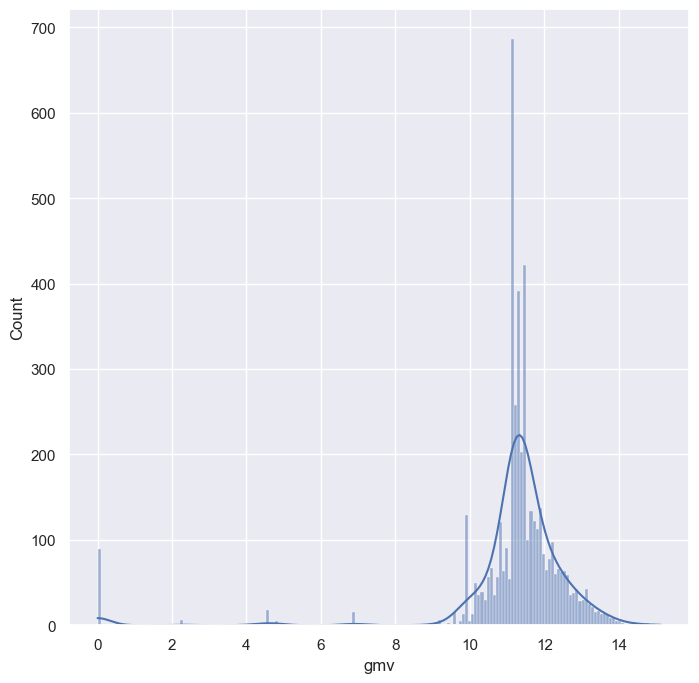

In [17]:
plt.figure(figsize=(8,8))

sns.histplot(data=transaction, x=np.log(transaction['gmv']), kde=True)


## All condition to consider to choose whose buyer is abuse the promotion campaign

1. The total promotion they use and the percentage promotion they use in total order they placed

2. The range of order they use promotion (if they range in 67.000 to 100.000 VNĐ => the sign to consider)

3. The time difference between they use promotion, because if they use quickly for each order value in (67;100) => they wait and use it for fast

In [18]:
date_promo_count = transaction.groupby(by=['date'])['rebate_using'].sum()
date_promo_count

date
2019-10-30     795
2019-10-31     933
2019-11-01     959
2019-11-02    1436
Name: rebate_using, dtype: int64

The number of days with Promotion usage increases progressively day by day, with the final day having the highest usage of promotions.

In [19]:
transaction.groupby(by=['date'])['gmv'].sum()

date
2019-10-30    131357099
2019-10-31    158087327
2019-11-01    129886834
2019-11-02    221529847
Name: gmv, dtype: int64

In [20]:
customer_using = transaction.groupby(by=['date', 'uid']).\
                 agg(
                    gmv=('gmv','sum'),
                    rebate_using=('rebate_using','sum'),
                    total_order=('order_id','count')
                 )
customer_using = customer_using.sort_values(by=['date','gmv'], ascending= [True,False])
customer_using = customer_using.reset_index()
customer_using

,date,uid,gmv,rebate_using,total_order
0,2019-10-30,1775175,3750000,1,1
1,2019-10-30,100760866,2550000,1,1
2,2019-10-30,104049030,2160000,1,1
3,2019-10-30,1615169,1814000,1,1
4,2019-10-30,103821692,1380000,1,1
...,...,...,...,...,...
3754,2019-11-02,102172416,15000,1,1
3755,2019-11-02,103885650,10000,1,1
3756,2019-11-02,100352740,2,0,2
3757,2019-11-02,100619769,1,0,1


In [21]:
scaler = MinMaxScaler()

In [22]:
customer_using['normalized_gmv'] = scaler.fit_transform(customer_using[['gmv']])
customer_using['normalized_rebate_using'] = scaler.fit_transform(customer_using[['rebate_using']])

<Figure size 1200x1200 with 0 Axes>

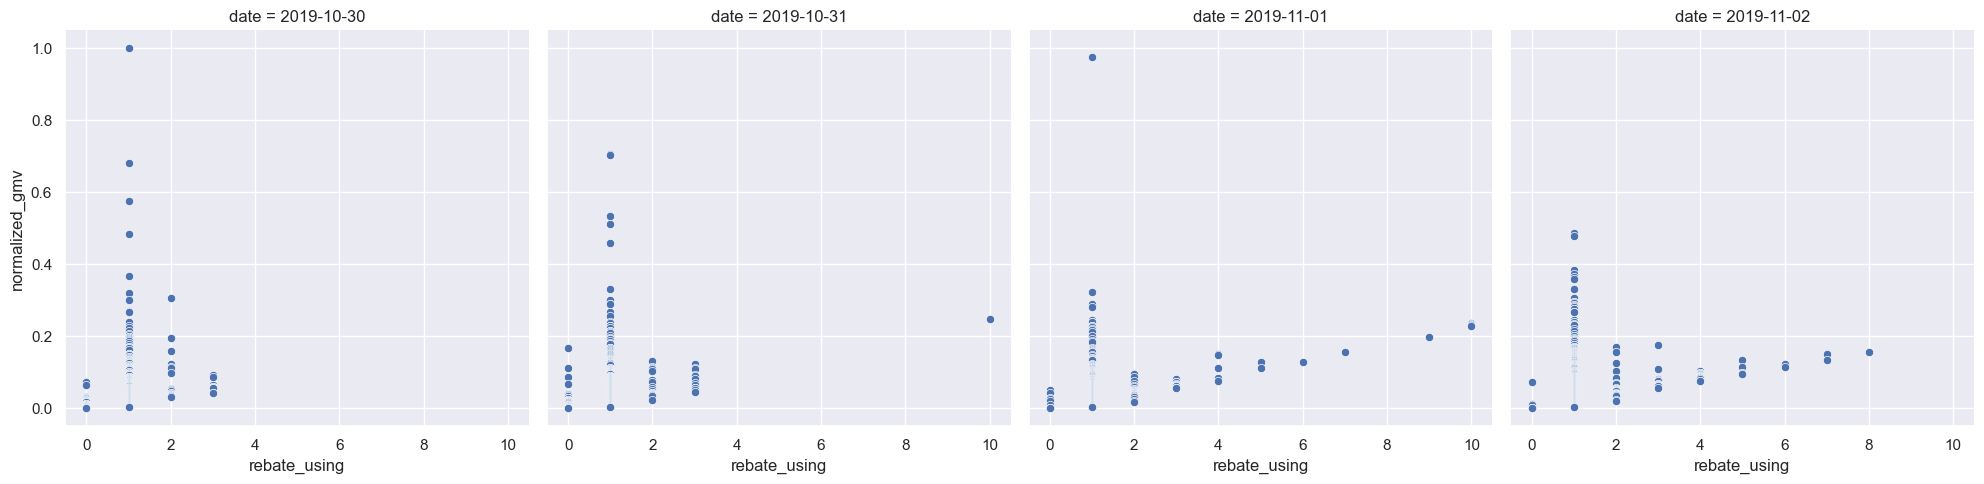

In [23]:
plt.figure(figsize=(12,12))

sns.relplot(data=customer_using, x='rebate_using', y='normalized_gmv', col='date')

<Figure size 1200x1200 with 0 Axes>

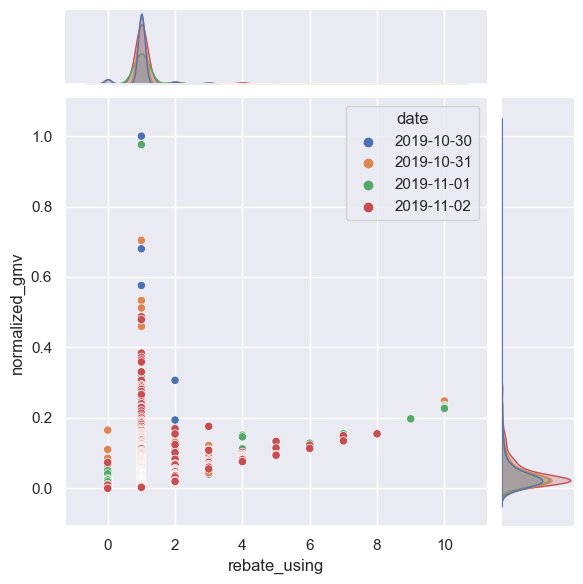

In [24]:
plt.figure(figsize=(12,12))

sns.jointplot(data=customer_using, x='rebate_using', y='normalized_gmv', hue='date')

In [25]:
customer_using[customer_using['rebate_using'].isin([8,9,10])]

,date,uid,gmv,rebate_using,total_order,normalized_gmv,normalized_rebate_using
812,2019-10-31,103868446,930000,10,10,0.248000,1.0
1739,2019-11-01,103023839,882000,10,10,0.235200,1.0
1740,2019-11-01,103653018,870000,10,10,0.232000,1.0
1741,2019-11-01,103667901,860000,10,10,0.229333,1.0
1744,2019-11-01,103653392,850000,10,10,0.226666,1.0
1750,2019-11-01,103366324,740000,9,9,0.197333,0.9
2601,2019-11-02,103044781,580000,8,8,0.154666,0.8


There are 5 customers using total 10 promotion vouchers, so they must put under the surveillance of Shopee platform

In [26]:
customer_abnormaly = transaction[transaction['uid'].isin([103868446, 103023839, 103653018, 103667901, 103653392, 103044781])]
customer_abnormaly

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group
1467,2019-11-01 14:32:00,142521919,103023839,4342,103284688,70000,20000,2019-11-01,14:32:00,1,50000,20000.0,"(67000, 100000]"
1521,2019-11-01 14:37:00,142524201,103023839,4809,103333474,100000,20000,2019-11-01,14:37:00,1,80000,20000.0,"(67000, 100000]"
1589,2019-11-01 15:02:00,142532417,103023839,5786,103481792,142000,20000,2019-11-01,15:02:00,1,122000,20000.0,"(100000, 200000]"
1593,2019-11-01 15:01:00,142531887,103023839,5808,103483282,105000,20000,2019-11-01,15:01:00,1,85000,20000.0,"(100000, 200000]"
1607,2019-11-01 14:33:00,142522583,103023839,5956,103488979,80000,20000,2019-11-01,14:33:00,1,60000,20000.0,"(67000, 100000]"
1685,2019-11-01 14:28:00,142520405,103023839,6840,103562487,75000,20000,2019-11-01,14:28:00,1,55000,20000.0,"(67000, 100000]"
1686,2019-11-01 14:25:00,142518886,103023839,6909,103568418,70000,20000,2019-11-01,14:25:00,1,50000,20000.0,"(67000, 100000]"
1689,2019-11-01 14:26:00,142519604,103023839,6917,103569882,80000,20000,2019-11-01,14:26:00,1,60000,20000.0,"(67000, 100000]"
1704,2019-11-01 14:30:00,142521236,103023839,7181,103571723,85000,20000,2019-11-01,14:30:00,1,65000,20000.0,"(67000, 100000]"
1728,2019-11-01 14:35:00,142523184,103023839,7653,103662116,75000,20000,2019-11-01,14:35:00,1,55000,20000.0,"(67000, 100000]"


In [27]:
customer_abnormaly['shop_id'].value_counts() # có 7 shop xuất hiện 6 lần, 3 shop xuất hiện 5 lần, chưa chắc
# customer_abnormaly['shop_owner_uid'].value_counts() # giống shop_id, không quá rõ ràng

shop_id
4342    5
6909    5
4809    5
7181    5
6917    5
7653    5
6840    5
5956    5
5808    5
5786    5
1773    1
1782    1
1915    1
2381    1
3230    1
3232    1
3891    1
7646    1
Name: count, dtype: int64

In [28]:
metric_customer = transaction.groupby(by=['txn_time','date','time','uid','shop_id']).\
                        agg(
                            gmv=('gmv','sum'),
                            rebate_using=('rebate_using','sum'),
                            total_order=('txn_time','count')
                        )
metric_customer = metric_customer.reset_index()
metric_customer['time_differ'] = metric_customer.groupby(by=['uid'])['txn_time'].diff()
metric_customer['hour'] = metric_customer['txn_time'].dt.hour
metric_customer['order_value_check'] = (metric_customer['gmv'] >= 67000) & (metric_customer['gmv'] <= 100000)
metric_customer['order_value_check'] = metric_customer['order_value_check'].map({True:1, False:0})
metric_customer.sort_values(by=['uid','txn_time'])

,txn_time,date,time,uid,shop_id,gmv,rebate_using,total_order,time_differ,hour,order_value_check
811,2019-10-30 20:54:00,2019-10-30,20:54:00,1002600,28170,79000,1,1,NaT,20,1
1152,2019-10-31 12:10:00,2019-10-31,12:10:00,1008042,605,35000,1,1,NaT,12,0
1148,2019-10-31 12:09:00,2019-10-31,12:09:00,1021839,605,50000,1,1,NaT,12,0
103,2019-10-30 10:09:00,2019-10-30,10:09:00,1026737,29824,1,0,1,NaT,10,0
116,2019-10-30 10:26:00,2019-10-30,10:26:00,1026737,29826,1,0,1,0 days 00:17:00,10,0
...,...,...,...,...,...,...,...,...,...,...,...
4289,2019-11-02 19:53:00,2019-11-02,19:53:00,104101238,28170,144000,1,1,NaT,19,0
4113,2019-11-02 18:25:00,2019-11-02,18:25:00,104101304,7783,157000,1,1,NaT,18,0
4283,2019-11-02 19:50:00,2019-11-02,19:50:00,104102194,29250,80000,1,1,NaT,19,1
4403,2019-11-02 20:48:00,2019-11-02,20:48:00,104102998,9967,1030000,1,1,NaT,20,0


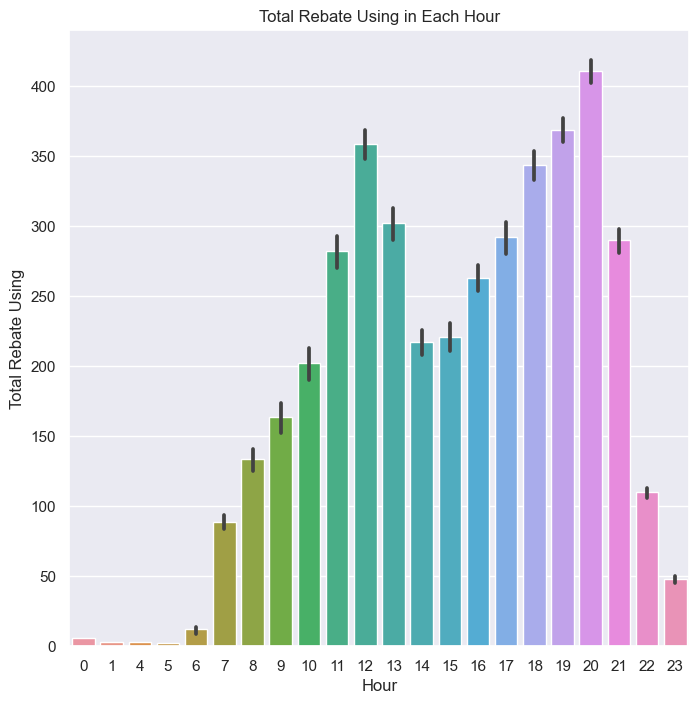

In [29]:
plt.figure(figsize=(8,8))

sns.barplot(data=metric_customer, x='hour', y='rebate_using', estimator=sum)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Rebate Using')
plt.title('Total Rebate Using in Each Hour')

# Show the chart
plt.show()

In [30]:
metric_customer_1 = metric_customer.groupby(by=['date', 'uid']).\
                        agg(
                            gmv=('gmv','sum'),
                            rebate_using=('rebate_using','sum'),
                            order_value_check=('order_value_check','sum'),
                            time_differ_total=('time_differ',lambda x: x.sum() if x.dtype == pd.Timedelta else pd.to_timedelta(x).sum()),
                            time_differ_mean=('time_differ',lambda x: x.mean() if x.dtype == pd.Timedelta else pd.to_timedelta(x).mean()),
                            total_order=('total_order','sum')
                        )
metric_customer_1 = metric_customer_1.reset_index()
metric_customer_1['aov/rebate'] = metric_customer_1['gmv'] / metric_customer_1['rebate_using']
metric_customer_1['pct_rebate_using'] = metric_customer_1['rebate_using'] / metric_customer_1['total_order'] * 100
metric_customer_1['pct_order_value_range'] = metric_customer_1['order_value_check'] / metric_customer_1['total_order'] * 100
metric_customer_1.sort_values(by=['time_differ_total','pct_rebate_using', 'order_value_check'], ascending=[True,False,False])

,date,uid,gmv,rebate_using,order_value_check,time_differ_total,time_differ_mean,total_order,aov/rebate,pct_rebate_using,pct_order_value_range
166,2019-10-30,100259747,134000,2,2,0 days 00:00:00,0 days 00:00:00,2,67000.0,100.0,100.0
1912,2019-11-01,100332933,134000,2,2,0 days 00:00:00,0 days 00:00:00,2,67000.0,100.0,100.0
2087,2019-11-01,101097078,134000,2,2,0 days 00:00:00,0 days 00:00:00,2,67000.0,100.0,100.0
2485,2019-11-01,103931392,134000,2,2,0 days 00:00:00,0 days 00:00:00,2,67000.0,100.0,100.0
0,2019-10-30,1002600,79000,1,1,0 days 00:00:00,NaT,1,79000.0,100.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
2569,2019-11-02,1432464,65000,1,0,3 days 04:59:00,3 days 04:59:00,1,65000.0,100.0,0.0
3657,2019-11-02,103793648,100000,1,1,3 days 07:06:00,3 days 07:06:00,1,100000.0,100.0,100.0
3144,2019-11-02,101335410,30000,1,0,3 days 07:11:00,3 days 07:11:00,1,30000.0,100.0,0.0
3399,2019-11-02,102697631,210000,2,1,3 days 07:19:00,1 days 15:39:30,2,105000.0,100.0,50.0


In [31]:
metric_customer_1.dtypes

date                              object
uid                                int64
gmv                                int64
rebate_using                       int64
order_value_check                  int64
time_differ_total        timedelta64[ns]
time_differ_mean         timedelta64[ns]
total_order                        int64
aov/rebate                       float64
pct_rebate_using                 float64
pct_order_value_range            float64
dtype: object

In [32]:
def rebate_using_kpi(rebate_column):
    if rebate_column <= 3:
        return 1
    elif rebate_column <= 7:
        return 2
    else:
        return 3

metric_customer_1['rebate_score'] = metric_customer_1['rebate_using'].apply(rebate_using_kpi)
metric_customer_1.sort_values(by=['rebate_score'], ascending=False)


def time_differ_score(time_score):
    time_score_td = pd.Timedelta(time_score)

    if time_score_td > pd.Timedelta(hours=1):
        return 1
    elif time_score_td > pd.Timedelta(minutes=10):
        return 2
    else:
        return 3

metric_customer_1['time_score'] = metric_customer_1['time_differ_mean'].apply(time_differ_score)

def pct_order_range_score(range_score):
    if range_score <= 30:
        return 1
    elif range_score <= 70:
        return 2
    else:
        return 3

metric_customer_1['order_range_score'] = metric_customer_1['pct_order_value_range'].apply(pct_order_range_score)
metric_customer_1['concat_score'] = metric_customer_1['rebate_score'].astype(str) + metric_customer_1['time_score'].astype(str) + metric_customer_1['order_range_score'].astype(str)
metric_customer_1.sort_values(by=['rebate_score'], ascending=False)

,date,uid,gmv,rebate_using,order_value_check,time_differ_total,time_differ_mean,total_order,aov/rebate,pct_rebate_using,pct_order_value_range,rebate_score,time_score,order_range_score,concat_score
3457,2019-11-02,103044781,580000,8,8,0 days 06:53:00,0 days 00:59:00,8,72500.000000,100.0,100.0,3,2,3,323
2298,2019-11-01,103023839,882000,10,8,0 days 00:37:00,0 days 00:04:06.666666666,10,88200.000000,100.0,80.0,3,3,3,333
2414,2019-11-01,103653018,870000,10,7,0 days 00:32:00,0 days 00:03:33.333333333,10,87000.000000,100.0,70.0,3,3,2,332
2415,2019-11-01,103653392,850000,10,10,0 days 01:26:00,0 days 00:09:33.333333333,10,85000.000000,100.0,100.0,3,3,3,333
2364,2019-11-01,103366324,740000,9,9,0 days 11:27:00,0 days 01:25:52.500000,9,82222.222222,100.0,100.0,3,1,3,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2019-10-31,101212540,98000,1,1,0 days 00:00:00,NaT,1,98000.000000,100.0,100.0,1,3,3,133
1258,2019-10-31,101216884,100000,1,1,0 days 00:00:00,NaT,1,100000.000000,100.0,100.0,1,3,3,133
1259,2019-10-31,101227449,160000,1,0,1 days 11:09:00,1 days 11:09:00,1,160000.000000,100.0,0.0,1,1,1,111
1260,2019-10-31,101227538,55000,1,0,0 days 00:00:00,NaT,1,55000.000000,100.0,0.0,1,3,1,131


In [33]:
metric_customer_1.to_csv('metric_customer.csv', index=False)

1. First, we need to filter which customer have rebate score in 3

2. Second, in the overall time_differ and range order value, if they higher in 3, they have the high possibility is abuse the promotion campaign for some ways, if they in 1 or 2, we need to more information to consider

In [34]:
customer_high_abuse = metric_customer_1[metric_customer_1['concat_score'].isin(['322', '333', '323', '332'])]
customer_high_abuse

,date,uid,gmv,rebate_using,order_value_check,time_differ_total,time_differ_mean,total_order,aov/rebate,pct_rebate_using,pct_order_value_range,rebate_score,time_score,order_range_score,concat_score
1654,2019-10-31,103868446,930000,10,9,0 days 00:33:00,0 days 00:03:40,10,93000.0,100.0,90.0,3,3,3,333
2298,2019-11-01,103023839,882000,10,8,0 days 00:37:00,0 days 00:04:06.666666666,10,88200.0,100.0,80.0,3,3,3,333
2414,2019-11-01,103653018,870000,10,7,0 days 00:32:00,0 days 00:03:33.333333333,10,87000.0,100.0,70.0,3,3,2,332
2415,2019-11-01,103653392,850000,10,10,0 days 01:26:00,0 days 00:09:33.333333333,10,85000.0,100.0,100.0,3,3,3,333
2421,2019-11-01,103667901,860000,10,10,0 days 00:38:00,0 days 00:04:13.333333333,10,86000.0,100.0,100.0,3,3,3,333
3457,2019-11-02,103044781,580000,8,8,0 days 06:53:00,0 days 00:59:00,8,72500.0,100.0,100.0,3,2,3,323


In [35]:
customer_abnormaly_1 = customer_abnormaly.groupby(by=['txn_time','date','time','uid','shop_id']).\
                        agg(
                            gmv=('gmv','sum'),
                            rebate_using=('rebate_using','sum'),
                            total_order=('txn_time','count')
                        )
customer_abnormaly_1 = customer_abnormaly_1.reset_index()
customer_abnormaly_1['time_differ'] = customer_abnormaly_1.groupby(by=['uid'])['txn_time'].diff()
customer_abnormaly_1['hour'] = customer_abnormaly_1['txn_time'].dt.hour
customer_abnormaly_1['order_value_check'] = (customer_abnormaly_1['gmv'] >= 67000) & (customer_abnormaly_1['gmv'] <= 100000)
customer_abnormaly_1['order_value_check'] = customer_abnormaly_1['order_value_check'].map({True:1, False:0})
customer_abnormaly_1.sort_values(by=['uid','txn_time'])

,txn_time,date,time,uid,shop_id,gmv,rebate_using,total_order,time_differ,hour,order_value_check
10,2019-11-01 14:25:00,2019-11-01,14:25:00,103023839,6909,70000,1,1,NaT,14,1
11,2019-11-01 14:26:00,2019-11-01,14:26:00,103023839,6917,80000,1,1,0 days 00:01:00,14,1
12,2019-11-01 14:28:00,2019-11-01,14:28:00,103023839,6840,75000,1,1,0 days 00:02:00,14,1
13,2019-11-01 14:30:00,2019-11-01,14:30:00,103023839,7181,85000,1,1,0 days 00:02:00,14,1
14,2019-11-01 14:32:00,2019-11-01,14:32:00,103023839,4342,70000,1,1,0 days 00:02:00,14,1
15,2019-11-01 14:33:00,2019-11-01,14:33:00,103023839,5956,80000,1,1,0 days 00:01:00,14,1
16,2019-11-01 14:35:00,2019-11-01,14:35:00,103023839,7653,75000,1,1,0 days 00:02:00,14,1
17,2019-11-01 14:37:00,2019-11-01,14:37:00,103023839,4809,100000,1,1,0 days 00:02:00,14,1
18,2019-11-01 15:01:00,2019-11-01,15:01:00,103023839,5808,105000,1,1,0 days 00:24:00,15,0
19,2019-11-01 15:02:00,2019-11-01,15:02:00,103023839,5786,142000,1,1,0 days 00:01:00,15,0


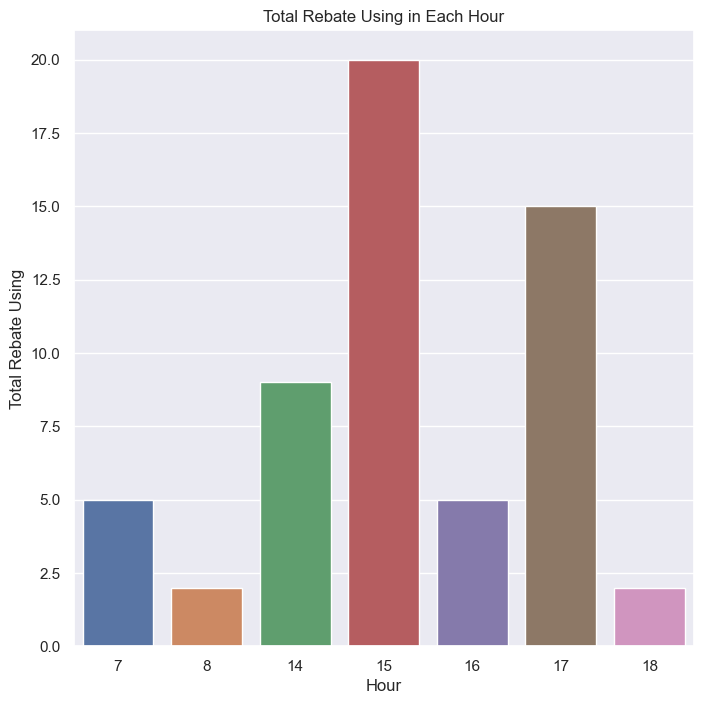

In [36]:
plt.figure(figsize=(8,8))

sns.barplot(data=customer_abnormaly_1, x='hour', y='rebate_using', estimator=sum)

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Rebate Using')
plt.title('Total Rebate Using in Each Hour')

# Show the chart
plt.show()

In [37]:
customer_abnormaly_1['shop_id'].value_counts()

shop_id
5956    5
6909    5
4342    5
7181    5
6917    5
6840    5
5786    5
5808    5
4809    5
7653    5
3230    1
1782    1
1773    1
2381    1
3232    1
3891    1
1915    1
7646    1
Name: count, dtype: int64

During the discount period, these 5 customers only made purchases on a single day, with high order values and using up to 10 vouchers each. This raises suspicions about potential fraudulent activity related to their promotion usage, as they seem to have waited for this period to make purchases.

In [38]:
customer_abnormaly_2 = customer_abnormaly_1.groupby(by=['date', 'uid']).\
                        agg(
                            gmv=('gmv','sum'),
                            rebate_using=('rebate_using','sum'),
                            order_value_check=('order_value_check','sum'),
                            time_differ_total=('time_differ',lambda x: x.sum() if x.dtype == pd.Timedelta else pd.to_timedelta(x).sum()),
                            time_differ_mean=('time_differ',lambda x: x.mean() if x.dtype == pd.Timedelta else pd.to_timedelta(x).mean()),
                            total_order=('total_order','sum')
                        )
customer_abnormaly_2 = customer_abnormaly_2.reset_index()
customer_abnormaly_2['aov/rebate'] = customer_abnormaly_2['gmv'] / customer_abnormaly_2['rebate_using']
customer_abnormaly_2['pct_rebate_using'] = customer_abnormaly_2['rebate_using'] / customer_abnormaly_2['total_order'] * 100
customer_abnormaly_2.sort_values(by=['time_differ_total','pct_rebate_using', 'order_value_check'], ascending=[True,False,False])

,date,uid,gmv,rebate_using,order_value_check,time_differ_total,time_differ_mean,total_order,aov/rebate,pct_rebate_using
2,2019-11-01,103653018,870000,10,7,0 days 00:32:00,0 days 00:03:33.333333333,10,87000.0,100.0
0,2019-10-31,103868446,930000,10,9,0 days 00:33:00,0 days 00:03:40,10,93000.0,100.0
1,2019-11-01,103023839,882000,10,8,0 days 00:37:00,0 days 00:04:06.666666666,10,88200.0,100.0
4,2019-11-01,103667901,860000,10,10,0 days 00:38:00,0 days 00:04:13.333333333,10,86000.0,100.0
3,2019-11-01,103653392,850000,10,10,0 days 01:26:00,0 days 00:09:33.333333333,10,85000.0,100.0
5,2019-11-02,103044781,580000,8,8,0 days 06:53:00,0 days 00:59:00,8,72500.0,100.0


### Conclusion

1. Regarding the frequency of promotion usage, there are 5 customers who used 10 promotions in a single day (the highest number in the dataset).

* Among these 5 customers, 4 of them utilized 10 promotions within a range of 32 to 38 minutes (averaging around 3-4 minutes per usage). This suggests that these customers segmented their orders into smaller groups and made multiple purchases simultaneously.

* Within this group of 4 customers, most of their purchases were in the price range of 67,000 to 100,000 VND, which is the range suitable for coupon application.

2. There is 1 customer who used 8 promotions and did so within 7 minutes, averaging less than 1 minute per usage.

=> Conclusion: Approximately 5 customers fall under a high-alert category for potentially exploiting promotions, while the remaining 2 customers are in a closely monitored category.

In [39]:
customer_abnormaly_2.to_csv('buyer_abuse.csv', index=False)

In [40]:
customer_abnormaly_3 = customer_abnormaly_1.groupby(by=['date','uid'])[['time_differ','rebate_using', 'order_value_check']].sum()
customer_abnormaly_3 = customer_abnormaly_3.reset_index()
customer_abnormaly_3 = customer_abnormaly_3.sort_values(by=['time_differ', 'order_value_check'], ascending = [True, False])
customer_abnormaly_3

,date,uid,time_differ,rebate_using,order_value_check
2,2019-11-01,103653018,0 days 00:32:00,10,7
0,2019-10-31,103868446,0 days 00:33:00,10,9
1,2019-11-01,103023839,0 days 00:37:00,10,8
4,2019-11-01,103667901,0 days 00:38:00,10,10
3,2019-11-01,103653392,0 days 01:26:00,10,10
5,2019-11-02,103044781,0 days 06:53:00,8,8


In [41]:
customer_abnormaly_4 = customer_abnormaly_1.groupby(by=['uid'])['shop_id'].nunique()
customer_abnormaly_4

uid
103023839    10
103044781     8
103653018    10
103653392    10
103667901    10
103868446    10
Name: shop_id, dtype: int64

# Shop overview and detection

## Method to find seller abuse 

Verify if the customer groups with a high risk of abuse have transactions with the same store simultaneously. If such instances are found, it indicates potential collaboration between the store and the customer group.

Examine whether the revenue and the frequency of abuse from that store have experienced abnormal increases.

Step 1:

Investigate stores with high revenue and high rebate usage. However, it's important to note that high revenue doesn't necessarily imply exploitation. This data should be compared against revenue trends during non-promotional periods for a more accurate assessment.

Step 2:

Scrutinize stores that exhibit sudden spikes in revenue or a high usage of promotions, especially on days outside the promotional period, particularly Saturdays.
By following these steps, a comprehensive evaluation can be conducted to identify potential cases of exploitation and to ascertain if there are unusual revenue or promotional usage patterns associated with certain stores.


In [42]:
transaction['gmv'].describe().apply(lambda x: format(x,'f'))

count       4611.000000
mean      138985.275862
std       193990.408745
min            1.000000
25%        70000.000000
50%        84926.000000
75%       139000.000000
max      3750000.000000
Name: gmv, dtype: object

Realizing that there are orders of 0 VND, if this program only applies 1 type of discount code, it cannot have low value orders (< 1000 VND)

In [43]:
order_low1000 = transaction[transaction['gmv'] < 1000]
order_low1000['hour'] = order_low1000['txn_time'].dt.hour
order_low1000

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group,hour
5,2019-10-30 10:31:00,141951971,100614916,10163,103915242,1,0,2019-10-30,10:31:00,0,1,0.3,"(0, 1000]",10
52,2019-10-30 10:50:00,141956702,102547028,10564,102615537,68,0,2019-10-30,10:50:00,0,68,20.4,"(0, 1000]",10
53,2019-10-30 11:01:00,141959539,102547028,10564,102615537,68,0,2019-10-30,11:01:00,0,68,20.4,"(0, 1000]",11
153,2019-10-30 14:44:00,142034827,100614916,1240,103015138,1,0,2019-10-30,14:44:00,0,1,0.3,"(0, 1000]",14
171,2019-10-30 12:51:00,141994408,100393963,2084,102582879,123,0,2019-10-30,12:51:00,0,123,36.9,"(0, 1000]",12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2439,2019-11-01 17:34:00,142572357,100027680,30202,100361622,1,0,2019-11-01,17:34:00,0,1,0.3,"(0, 1000]",17
3675,2019-11-02 09:51:00,142694952,100619769,30219,104095378,1,0,2019-11-02,09:51:00,0,1,0.3,"(0, 1000]",9
3676,2019-11-02 12:05:00,142726425,100352740,30223,104095417,1,0,2019-11-02,12:05:00,0,1,0.3,"(0, 1000]",12
3677,2019-11-02 12:05:00,142726479,100352740,30223,104095417,1,0,2019-11-02,12:05:00,0,1,0.3,"(0, 1000]",12


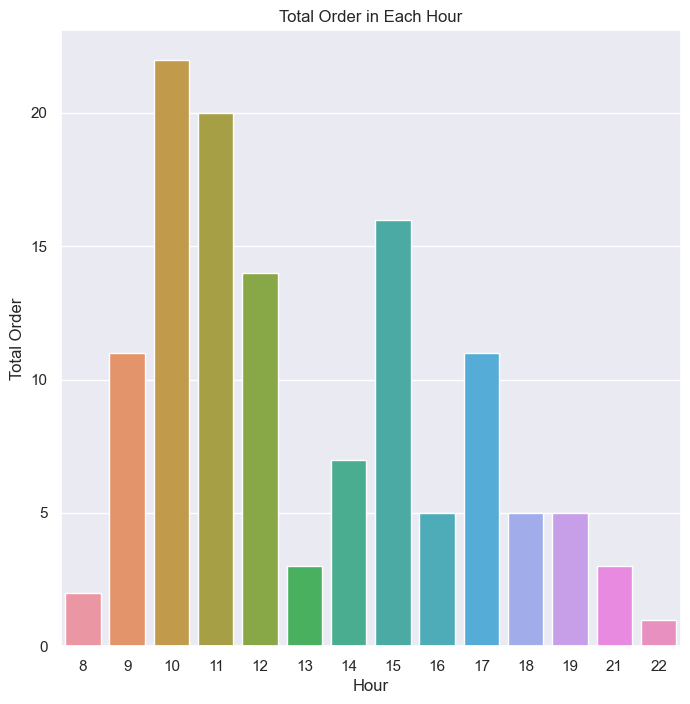

In [44]:
plt.figure(figsize=(8,8))

sns.countplot(data=order_low1000, x='hour')

# Add labels and title
plt.xlabel('Hour')
plt.ylabel('Total Order')
plt.title('Total Order in Each Hour')

# Show the chart
plt.show()

In [45]:
order_low1000['time_differ'] = order_low1000.groupby(by=['shop_id'])['txn_time'].diff()
order_low1000.sort_values(by=['shop_id', 'txn_time'], ascending=[True, True])

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group,hour,time_differ
153,2019-10-30 14:44:00,142034827,100614916,1240,103015138,1,0,2019-10-30,14:44:00,0,1,0.3,"(0, 1000]",14,NaT
171,2019-10-30 12:51:00,141994408,100393963,2084,102582879,123,0,2019-10-30,12:51:00,0,123,36.9,"(0, 1000]",12,NaT
426,2019-10-30 10:38:00,141953525,1026737,3690,103203317,1,0,2019-10-30,10:38:00,0,1,0.3,"(0, 1000]",10,NaT
444,2019-10-30 12:43:00,141992560,100393963,4332,103255536,123,0,2019-10-30,12:43:00,0,123,36.9,"(0, 1000]",12,NaT
717,2019-10-30 18:39:00,142092453,100397082,8168,103714638,1,0,2019-10-30,18:39:00,0,1,0.3,"(0, 1000]",18,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,2019-11-01 17:07:00,142565732,100352740,30195,103097804,1,0,2019-11-01,17:07:00,0,1,0.3,"(0, 1000]",17,NaT
2439,2019-11-01 17:34:00,142572357,100027680,30202,100361622,1,0,2019-11-01,17:34:00,0,1,0.3,"(0, 1000]",17,NaT
3675,2019-11-02 09:51:00,142694952,100619769,30219,104095378,1,0,2019-11-02,09:51:00,0,1,0.3,"(0, 1000]",9,NaT
3676,2019-11-02 12:05:00,142726425,100352740,30223,104095417,1,0,2019-11-02,12:05:00,0,1,0.3,"(0, 1000]",12,NaT


In [46]:
order_low1000[order_low1000['uid'] == 100605978]

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group,hour,time_differ
380,2019-10-30 15:50:00,142056861,100605978,29923,104055260,1,0,2019-10-30,15:50:00,0,1,0.3,"(0, 1000]",15,NaT
381,2019-10-30 15:52:00,142057199,100605978,29923,104055260,1,0,2019-10-30,15:52:00,0,1,0.3,"(0, 1000]",15,0 days 00:02:00
1377,2019-10-31 15:26:00,142293708,100605978,30061,104069928,1,0,2019-10-31,15:26:00,0,1,0.3,"(0, 1000]",15,NaT
1378,2019-10-31 15:27:00,142294036,100605978,30061,104069928,1,0,2019-10-31,15:27:00,0,1,0.3,"(0, 1000]",15,0 days 00:01:00
2078,2019-11-01 11:56:00,142475264,100605978,10605,101417978,1,0,2019-11-01,11:56:00,0,1,0.3,"(0, 1000]",11,NaT
2416,2019-11-01 09:41:00,142438856,100605978,30127,104079648,1,0,2019-11-01,09:41:00,0,1,0.3,"(0, 1000]",9,NaT
2417,2019-11-01 09:41:00,142438908,100605978,30127,104079648,1,0,2019-11-01,09:41:00,0,1,0.3,"(0, 1000]",9,0 days 00:00:00
2418,2019-11-01 10:16:00,142446305,100605978,30140,104080159,1,0,2019-11-01,10:16:00,0,1,0.3,"(0, 1000]",10,NaT
2419,2019-11-01 10:16:00,142446346,100605978,30140,104080159,1,0,2019-11-01,10:16:00,0,1,0.3,"(0, 1000]",10,0 days 00:00:00
2420,2019-11-01 10:31:00,142449544,100605978,30140,104080159,1,0,2019-11-01,10:31:00,0,1,0.3,"(0, 1000]",10,0 days 00:15:00


In [47]:
transaction[transaction['uid'] == 100605978]

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group
380,2019-10-30 15:50:00,142056861,100605978,29923,104055260,1,0,2019-10-30,15:50:00,0,1,0.3,"(0, 1000]"
381,2019-10-30 15:52:00,142057199,100605978,29923,104055260,1,0,2019-10-30,15:52:00,0,1,0.3,"(0, 1000]"
1377,2019-10-31 15:26:00,142293708,100605978,30061,104069928,1,0,2019-10-31,15:26:00,0,1,0.3,"(0, 1000]"
1378,2019-10-31 15:27:00,142294036,100605978,30061,104069928,1,0,2019-10-31,15:27:00,0,1,0.3,"(0, 1000]"
2078,2019-11-01 11:56:00,142475264,100605978,10605,101417978,1,0,2019-11-01,11:56:00,0,1,0.3,"(0, 1000]"
2201,2019-11-01 06:52:00,142415557,100605978,1559,103028107,69000,20000,2019-11-01,06:52:00,1,49000,20000.0,"(67000, 100000]"
2416,2019-11-01 09:41:00,142438856,100605978,30127,104079648,1,0,2019-11-01,09:41:00,0,1,0.3,"(0, 1000]"
2417,2019-11-01 09:41:00,142438908,100605978,30127,104079648,1,0,2019-11-01,09:41:00,0,1,0.3,"(0, 1000]"
2418,2019-11-01 10:16:00,142446305,100605978,30140,104080159,1,0,2019-11-01,10:16:00,0,1,0.3,"(0, 1000]"
2419,2019-11-01 10:16:00,142446346,100605978,30140,104080159,1,0,2019-11-01,10:16:00,0,1,0.3,"(0, 1000]"


In [48]:
order_low_overview = order_low1000.groupby(by=['shop_owner_uid','shop_id', 'date']).\
                     agg(
                         total_order = ('order_id','count'),
                         total_time_differ = ('time_differ', 'sum')
                     ).reset_index()
order_low_overview.sort_values(by='total_order', ascending=False)
order_low1 = order_low_overview[order_low_overview['total_order'] >= 3].sort_values(by='total_order', ascending=False)
order_low1

,shop_owner_uid,shop_id,date,total_order,total_time_differ
95,104080159,30140,2019-11-01,4,0 days 00:15:00
65,103932347,30185,2019-11-01,3,0 days 00:04:00
96,104081012,30148,2019-11-01,3,0 days 00:05:00


In [49]:
order_low1.to_csv('order_low1.csv', index=False)

In [50]:
order_low1['shop_owner_uid'].value_counts()

shop_owner_uid
104080159    1
103932347    1
104081012    1
Name: count, dtype: int64

In [51]:
shop_revenue = transaction.groupby(by=['txn_time','date','time','shop_owner_uid','shop_id'])[['gmv', 'rebate_using']].\
               agg({'gmv': np.sum, 'rebate_using':np.sum})
shop_revenue = shop_revenue.reset_index()
shop_revenue['hour'] = shop_revenue['txn_time'].dt.hour
shop_revenue

,txn_time,date,time,shop_owner_uid,shop_id,gmv,rebate_using,hour
0,2019-10-30 00:00:00,2019-10-30,00:00:00,103282856,4164,496000,1,0
1,2019-10-30 00:23:00,2019-10-30,00:23:00,103280547,4673,48000,1,0
2,2019-10-30 00:47:00,2019-10-30,00:47:00,1873720,9096,70000,1,0
3,2019-10-30 00:59:00,2019-10-30,00:59:00,103157062,10824,87000,1,0
4,2019-10-30 01:19:00,2019-10-30,01:19:00,103157062,10824,25000,1,1
...,...,...,...,...,...,...,...,...
4508,2019-11-02 23:35:00,2019-11-02,23:35:00,103498999,6050,135000,1,23
4509,2019-11-02 23:37:00,2019-11-02,23:37:00,103498440,6030,135000,1,23
4510,2019-11-02 23:38:00,2019-11-02,23:38:00,103498278,6072,135000,1,23
4511,2019-11-02 23:47:00,2019-11-02,23:47:00,1621933,1238,100000,1,23


In [52]:
shop_revenue_1 = shop_revenue.groupby(by=['date','shop_owner_uid']).\
                 agg(
                     gmv_sum=('gmv', 'sum'),
                     rebate_using_sum=('rebate_using', 'sum'),
                     rebate_using_count=('rebate_using', 'size')
                 )
shop_revenue_1 = shop_revenue_1.reset_index()
shop_revenue_1 = shop_revenue_1.sort_values(by=['date','rebate_using_sum', 'gmv_sum'], ascending=[True, False, False])
shop_revenue_1

,date,shop_owner_uid,gmv_sum,rebate_using_sum,rebate_using_count
236,2019-10-30,102817559,3095000,33,41
302,2019-10-30,103280547,999000,10,10
139,2019-10-30,100530690,620000,10,10
410,2019-10-30,103835793,700000,8,8
289,2019-10-30,103192062,460000,8,8
...,...,...,...,...,...
1956,2019-11-02,103391470,27000,1,1
2089,2019-11-02,103895112,26000,1,1
2058,2019-11-02,103796559,21000,1,1
2141,2019-11-02,104095417,2,0,1


In [53]:
gmv_2d = shop_revenue_1['gmv_sum'].values.reshape(-1, 1)
rebate_using_2d = shop_revenue_1['rebate_using_sum'].values.reshape(-1, 1)
shop_revenue_1['normalize_gmv'] = scaler.fit_transform(gmv_2d)
shop_revenue_1['normalize_gmv'] = shop_revenue_1['normalize_gmv'].apply(lambda x: format(x, 'f')).astype(float)
shop_revenue_1['normalize_rebate_using_sum'] = scaler.fit_transform(rebate_using_2d)
shop_revenue_1['normalize_rebate_using_sum'] = shop_revenue_1['normalize_rebate_using_sum'].apply(lambda x: format(x, 'f')).astype(float)
shop_revenue_1

,date,shop_owner_uid,gmv_sum,rebate_using_sum,rebate_using_count,normalize_gmv,normalize_rebate_using_sum
236,2019-10-30,102817559,3095000,33,41,0.470866,0.507692
302,2019-10-30,103280547,999000,10,10,0.151985,0.153846
139,2019-10-30,100530690,620000,10,10,0.094325,0.153846
410,2019-10-30,103835793,700000,8,8,0.106496,0.123077
289,2019-10-30,103192062,460000,8,8,0.069983,0.123077
...,...,...,...,...,...,...,...
1956,2019-11-02,103391470,27000,1,1,0.004108,0.015385
2089,2019-11-02,103895112,26000,1,1,0.003955,0.015385
2058,2019-11-02,103796559,21000,1,1,0.003195,0.015385
2141,2019-11-02,104095417,2,0,1,0.000000,0.000000


In [54]:
shop_revenue_1['gmv_sum'].describe().apply(lambda x: format(x, 'f'))

count       2142.000000
mean      299188.191877
std       416579.546759
min            1.000000
25%        92000.000000
50%       165000.000000
75%       335000.000000
max      6573000.000000
Name: gmv_sum, dtype: object

GMV shows mean > median => left skewed graph

In [55]:
shop_revenue_1['rebate_using_sum'].value_counts()

rebate_using_sum
1     1275
2      391
3      157
4       87
0       86
5       55
6       32
7       12
8       10
10       8
11       6
12       5
23       4
9        3
13       2
65       1
19       1
18       1
33       1
20       1
34       1
15       1
40       1
21       1
Name: count, dtype: int64

In [56]:
shop_revenue_1.dtypes

date                           object
shop_owner_uid                  int64
gmv_sum                         int64
rebate_using_sum                int64
rebate_using_count              int64
normalize_gmv                 float64
normalize_rebate_using_sum    float64
dtype: object

<Figure size 800x800 with 0 Axes>

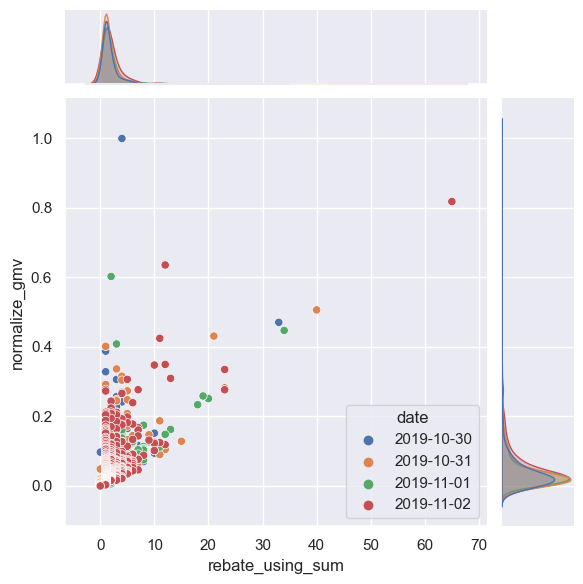

In [57]:
# Visual
plt.figure(figsize=(8,8))

sns.jointplot(data=shop_revenue_1, x='rebate_using_sum', y='normalize_gmv', hue='date')

In [58]:
shop_revenue_1[shop_revenue_1['normalize_rebate_using_sum'] >= 0.5]

,date,shop_owner_uid,gmv_sum,rebate_using_sum,rebate_using_count,normalize_gmv,normalize_rebate_using_sum
236,2019-10-30,102817559,3095000,33,41,0.470866,0.507692
742,2019-10-31,102817559,3330000,40,44,0.506618,0.615385
1244,2019-11-01,102817559,2941500,34,43,0.447512,0.523077
1822,2019-11-02,102817559,5380049,65,80,0.818507,1.000000


In [59]:
shop_revenue_abnormaly = shop_revenue[shop_revenue['shop_owner_uid'] == 102817559]
shop_revenue_abnormaly

,txn_time,date,time,shop_owner_uid,shop_id,gmv,rebate_using,hour
42,2019-10-30 08:48:00,2019-10-30,08:48:00,102817559,10979,90000,1,8
45,2019-10-30 08:51:00,2019-10-30,08:51:00,102817559,10979,100000,1,8
47,2019-10-30 08:53:00,2019-10-30,08:53:00,102817559,10979,80000,1,8
48,2019-10-30 08:55:00,2019-10-30,08:55:00,102817559,10979,80000,1,8
49,2019-10-30 08:56:00,2019-10-30,08:56:00,102817559,10979,90000,1,8
...,...,...,...,...,...,...,...,...
4412,2019-11-02 21:18:00,2019-11-02,21:18:00,102817559,10979,95000,1,21
4416,2019-11-02 21:20:00,2019-11-02,21:20:00,102817559,10979,70000,1,21
4435,2019-11-02 21:34:00,2019-11-02,21:34:00,102817559,10979,110000,1,21
4439,2019-11-02 21:38:00,2019-11-02,21:38:00,102817559,10979,75000,1,21


In [60]:
shop_revenue_abnormaly_1 = shop_revenue_abnormaly.groupby(by=['date','shop_id']).\
                           agg(
                             gmv = ('gmv','sum'),
                             rebate_using = ('rebate_using','sum'),
                             all_transaction = ('rebate_using','count')  
                           )
shop_revenue_abnormaly_1 = shop_revenue_abnormaly_1.reset_index()
shop_revenue_abnormaly_1['date'] = pd.to_datetime(shop_revenue_abnormaly_1['date'])
shop_revenue_abnormaly_1['rebate_pct%'] = shop_revenue_abnormaly_1['rebate_using'] / shop_revenue_abnormaly_1['all_transaction'] * 100
shop_revenue_abnormaly_1['rebate_pct%'] = shop_revenue_abnormaly_1['rebate_pct%'].round(2)
shop_revenue_abnormaly_1['date'] = pd.to_datetime(shop_revenue_abnormaly_1['date'])
shop_revenue_abnormaly_1

,date,shop_id,gmv,rebate_using,all_transaction,rebate_pct%
0,2019-10-30,10979,3095000,33,41,80.49
1,2019-10-31,10979,3330000,40,44,90.91
2,2019-11-01,10979,2941500,34,43,79.07
3,2019-11-02,10979,5380049,65,80,81.25


In [61]:
shop_revenue_abnormaly_1.dtypes

date               datetime64[ns]
shop_id                     int64
gmv                         int64
rebate_using                int64
all_transaction             int64
rebate_pct%               float64
dtype: object

<Axes: xlabel='date', ylabel='gmv'>

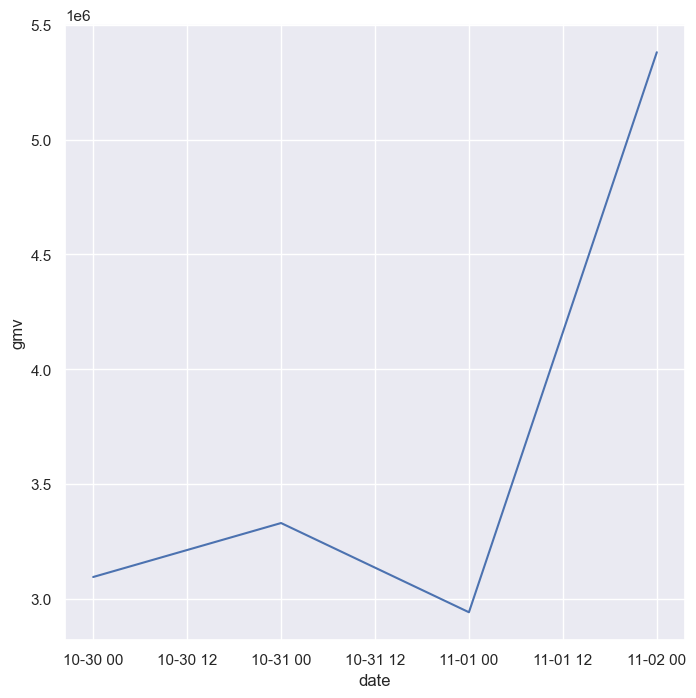

In [62]:
# Visual
plt.figure(figsize=(8,8))

sns.lineplot(data=shop_revenue_abnormaly_1, x='date', y='gmv')

In [63]:
shop_revenue_2 = shop_revenue.groupby(by=['date','shop_id']).\
                 agg(
                     gmv_sum=('gmv', 'sum'),
                     rebate_using_sum=('rebate_using', 'sum'),
                     rebate_using_count=('rebate_using', 'size')
                 )
shop_revenue_2 = shop_revenue_2.reset_index()
shop_revenue_2 = shop_revenue_2.sort_values(by=['date','rebate_using_sum', 'gmv_sum'], ascending=[True, False, False])
shop_revenue_2['pct_gmv'] = shop_revenue_2.groupby(by=['shop_id'])['gmv_sum'].pct_change()
shop_revenue_2['pct_rebate'] = shop_revenue_2.groupby(by=['shop_id'])['rebate_using_sum'].pct_change()
shop_revenue_2[shop_revenue_2['pct_gmv'] >= 50]

,date,shop_id,gmv_sum,rebate_using_sum,rebate_using_count,pct_gmv,pct_rebate
589,2019-10-31,3690,190000,1,1,189999.000000,inf
1575,2019-11-01,29660,211500,2,2,2114.000000,inf
1519,2019-11-01,28106,898200,1,1,898199.000000,inf
1591,2019-11-01,29972,230000,1,2,1868.918699,inf
2152,2019-11-02,27031,408100,2,2,408099.000000,inf
2267,2019-11-02,29917,623000,1,1,622999.000000,inf
2281,2019-11-02,30064,230000,1,1,229.000000,inf
2259,2019-11-02,29767,105000,1,1,1049.000000,inf
2274,2019-11-02,30006,70000,1,1,69999.000000,inf


In [64]:
shop_revenue_2_check = shop_revenue_2.sort_values(by=['shop_id','date'],ascending=[True,True])
shop_revenue_2_check_1 = shop_revenue_2_check.groupby(by=['shop_id'])['gmv_sum'].pct_change().rename({'gmv_sum':'pct_change'})
shop_revenue_2_check_1 = pd.DataFrame(shop_revenue_2_check_1)
shop_revenue_2_check_1

,gmv_sum
504,NaN
1092,0.122340
0,NaN
505,NaN
1093,NaN
...,...
1611,NaN
1612,NaN
2286,1.539995
2287,NaN


In [65]:
shop_revenue_2_check_1[shop_revenue_2_check_1['gmv_sum'] >= 1]

,gmv_sum
1613,1.746269
508,5.815920
1616,2.000000
511,11.036364
1622,1.106383
...,...
1591,1868.918699
2273,8.722168
2274,69999.000000
2281,229.000000


In [66]:
transaction[transaction['shop_id'] == 29767]

,txn_time,order_id,uid,shop_id,shop_owner_uid,gmv,rebate,date,time,rebate_using,order_value,rebate_test,gmv_group
1327,2019-10-31 15:53:00,142303317,100205391,29767,1011910,100,0,2019-10-31,15:53:00,0,100,30.0,"(0, 1000]"
3628,2019-11-02 16:28:00,142794480,100103817,29767,1011910,105000,20000,2019-11-02,16:28:00,1,85000,20000.0,"(100000, 200000]"


In [67]:
shop_revenue_2_check = shop_revenue_2.sort_values(by=['shop_id','date'],ascending=[True,True])
shop_revenue_2_check_2 = shop_revenue_2_check.groupby(by=['shop_id'])['rebate_using_sum'].pct_change()
shop_revenue_2_check_2 = pd.DataFrame(shop_revenue_2_check_2)
shop_revenue_2_check['pct_rebate_change'] = shop_revenue_2_check_2['rebate_using_sum']
shop_revenue_2_check['pct_change'] = shop_revenue_2_check_1['gmv_sum']
shop_revenue_3 = shop_revenue_2_check[shop_revenue_2_check['pct_change'] >= 1]
shop_revenue_3 = shop_revenue_3.groupby(by=['shop_id']).filter(lambda x: len(x) >= 2)
shop_revenue_3['shop_id'].array

<PandasArray>
[  790,   790,  4611,  4611,  4673,  4673,  5471,  5471,  5577,  5577,  6529,
  6529,  6788,  6788,  7855,  7855, 10523, 10523, 28170, 28170, 28172, 28172,
 28190, 28190, 29173, 29173, 29539, 29539]
Length: 28, dtype: int64

In [68]:
a = shop_revenue_2_check[(shop_revenue_2_check['pct_change']>= 1) & (shop_revenue_2_check['pct_rebate_change'] >= 1)]
much_increase = a.groupby(by=['date','shop_id']).\
                agg(
                    total_gmv=('gmv_sum','sum'),
                    total_rebate=('rebate_using_sum','sum')
                ).reset_index()
much_increase['pct_rebate'] = much_increase.groupby(by=['shop_id'])['total_rebate'].pct_change()
much_increase['pct_gmv'] = much_increase.groupby(by=['shop_id'])['total_gmv'].pct_change()
much_increase[much_increase['pct_gmv'] >= 1]

,date,shop_id,total_gmv,total_rebate,pct_rebate,pct_gmv
103,2019-11-02,5577,550000,5,1.50,1.750000
109,2019-11-02,6788,4180000,12,3.00,2.962085
115,2019-11-02,7855,465000,5,1.50,1.657143
144,2019-11-02,28172,927000,5,0.25,1.414062


In [69]:
shop_revenue_2_check_2 = shop_revenue_2_check.groupby(by=['shop_id'])['rebate_using_sum'].pct_change()
shop_revenue_2_check_2 = pd.DataFrame(shop_revenue_2_check_2)
shop_revenue_2_check['pct_rebate_change'] = shop_revenue_2_check_2['rebate_using_sum']
shop_revenue_2_check

,date,shop_id,gmv_sum,rebate_using_sum,rebate_using_count,pct_gmv,pct_rebate,pct_rebate_change,pct_change
504,2019-10-31,136,188000,2,2,NaN,NaN,NaN,NaN
1092,2019-11-01,136,211000,2,2,0.122340,0.0,0.0,0.122340
0,2019-10-30,166,116000,1,1,NaN,NaN,NaN,NaN
505,2019-10-31,191,81200,1,1,NaN,NaN,NaN,NaN
1093,2019-11-01,205,104000,1,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1611,2019-11-01,30195,1,0,1,NaN,NaN,NaN,NaN
1612,2019-11-01,30202,500001,2,3,NaN,NaN,NaN,NaN
2286,2019-11-02,30202,1270000,4,3,1.539995,1.0,1.0,1.539995
2287,2019-11-02,30219,1,0,1,NaN,NaN,NaN,NaN


In [70]:
shop_revenue_abnormaly_2 = shop_revenue[shop_revenue['shop_id'].isin([790,4611, 4673,5471, 5577, 6529,  6788,  7855, 10523,28170, 28172, 28190,29173, 29539])]
shop_revenue_abnormaly_2[shop_revenue_abnormaly_2['rebate_using'] >= 5]

,txn_time,date,time,shop_owner_uid,shop_id,gmv,rebate_using,hour
